**Ejercicio: Detección de anomalías UEBA**

En este ejercicio, consideramos un conjunto de datos de la actividad de red de una cuenta y 
un dispositivo en la red. Extraemos características de este registro de red simplificado y 
determinamos si existe tráfico anómalo que pueda indicar el robo de credenciales, 
infracciones de políticas o algo similar. 

Podemos observar que el conjunto de datos incluye un fragmento del tráfico de red de un día desde el dispositivo de un usuario llamado John Doe.

    • Username: El nombre de usuario del usuario del dispositivo.
    • Host IP: La dirección IP del dispositivo host.
    • RemoteIP: La dirección IP del dispositivo al que se conecta el usuario.
    • RemotePort: El puerto utilizado para conectarse al dispositivo remoto.
    • Date/Time: La fecha y hora de la conexión de red. 
    • HostLocation: La ubicación del host que utiliza el usuario.
    • RemoteIPLocation: La ubicación del host remoto. 
    • ProcessImage: El nombre del ejecutable que realiza la conexión de red en un dispositivo host.

El objetivo de este ejercicio es explorar este conjunto de datos, definir características y detectar si existen anomalías que deban preocuparnos en términos de riesgo de seguridad.

In [3]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 

df_ueba = pd.read_csv('C:\\Users\\Tacos\\OneDrive\\Documentos\\Universidad\\Curso - Datos, ciberseguridad e inteligencia artificial\\Actividades\\16 ueba.csv') 

**Exploratory data analysis (EDA)**

Ejemplos de código extraídos de: https://www.geeksforgeeks.org/data-analysis/exploratory-data-analysis-in-python/ 

In [4]:
display(df_ueba.head())

,Username,HostIP,RemoteIP,RemotePort,Date/Time,HostLocation,RemoteIPLocation,ProcessImage
0,John.Doe,192.168.1.2,10.0.1.4,389,23.12.2023 08:10:00,USA,USA,LDAP_Client.exe
1,John.Doe,192.168.1.2,10.0.1.4,464,23.12.2023 08:21:21,USA,USA,LDAP_Client.exe
2,John.Doe,192.168.1.2,10.0.1.4,636,23.12.2023 08:22:23,USA,USA,LDAP_Client.exe
3,John.Doe,192.168.1.2,10.0.1.4,464,23.12.2023 08:10:30,USA,USA,LDAP_Client.exe
4,John.Doe,192.168.1.2,10.0.1.5,3389,23.12.2023 09:01:25,USA,France,RDP_Client.exe


In [5]:
df_ueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Username          81 non-null     object
 1   HostIP            81 non-null     object
 2   RemoteIP          81 non-null     object
 3   RemotePort        81 non-null     int64 
 4   Date/Time         81 non-null     object
 5   HostLocation      81 non-null     object
 6   RemoteIPLocation  81 non-null     object
 7   ProcessImage      81 non-null     object
dtypes: int64(1), object(7)
memory usage: 5.2+ KB


In [6]:
df_ueba.describe(include='all')

,Username,HostIP,RemoteIP,RemotePort,Date/Time,HostLocation,RemoteIPLocation,ProcessImage
count,81,81,81,81.000000,81,81,81,81
unique,1,2,18,NaN,81,1,5,7
top,John.Doe,192.168.1.2,75.63.15.74,NaN,23.12.2023 08:10:00,USA,USA,HTTP_Client.exe
freq,81,46,8,NaN,1,81,71,58
mean,NaN,NaN,NaN,1587.691358,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,2841.218707,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,22.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,80.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,80.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,465.000000,NaN,NaN,NaN,NaN


Hay una columna que solo tiene dos valores posibles: HostIP. Esto se debe a que la IP de un host ha cambiado durante la recopilación de datos, lo que puede ocurrir si la dirección IP no está configurada como estática. Sin embargo, la actividad se realiza en el mismo host.

Tenemos una columna de Date/Time, que sería útil si tuviéramos varios días de datos, pero teniendo en cuenta que nuestro conjunto de datos contiene solo un día, no la usaremos para la detección de anomalías. Si tuviéramos varios días de datos, podríamos añadirla como una característica para comprobar si el evento ocurre en un período anómalo (por ejemplo, fuera del horario laboral). 

In [7]:
df_ueba.isnull().sum()

Username            0
HostIP              0
RemoteIP            0
RemotePort          0
Date/Time           0
HostLocation        0
RemoteIPLocation    0
ProcessImage        0
dtype: int64

Al parecer esta función no detecta los NaN como valores nulos.

In [8]:
df_ueba.nunique()

Username             1
HostIP               2
RemoteIP            18
RemotePort          10
Date/Time           81
HostLocation         1
RemoteIPLocation     5
ProcessImage         7
dtype: int64

Gráfico de densidad o histograma:

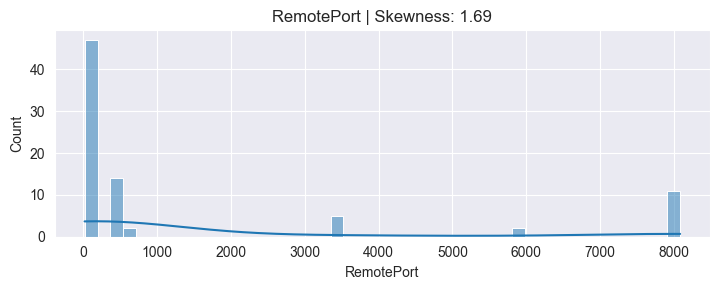

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

numerical_columns = df_ueba.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df_ueba[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df_ueba[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

Análisis bivariado: Pair plot

C:\Users\Tacos\.conda\envs\ai_security\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

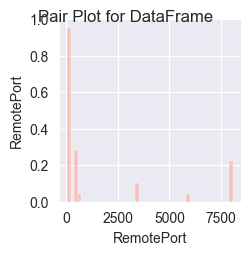

In [10]:
sns.set_palette("Pastel1")

plt.figure(figsize=(10, 6))

sns.pairplot(df_ueba)

plt.suptitle('Pair Plot for DataFrame')
plt.show()

Análisis multivariado: Matriz de correlación (plot)

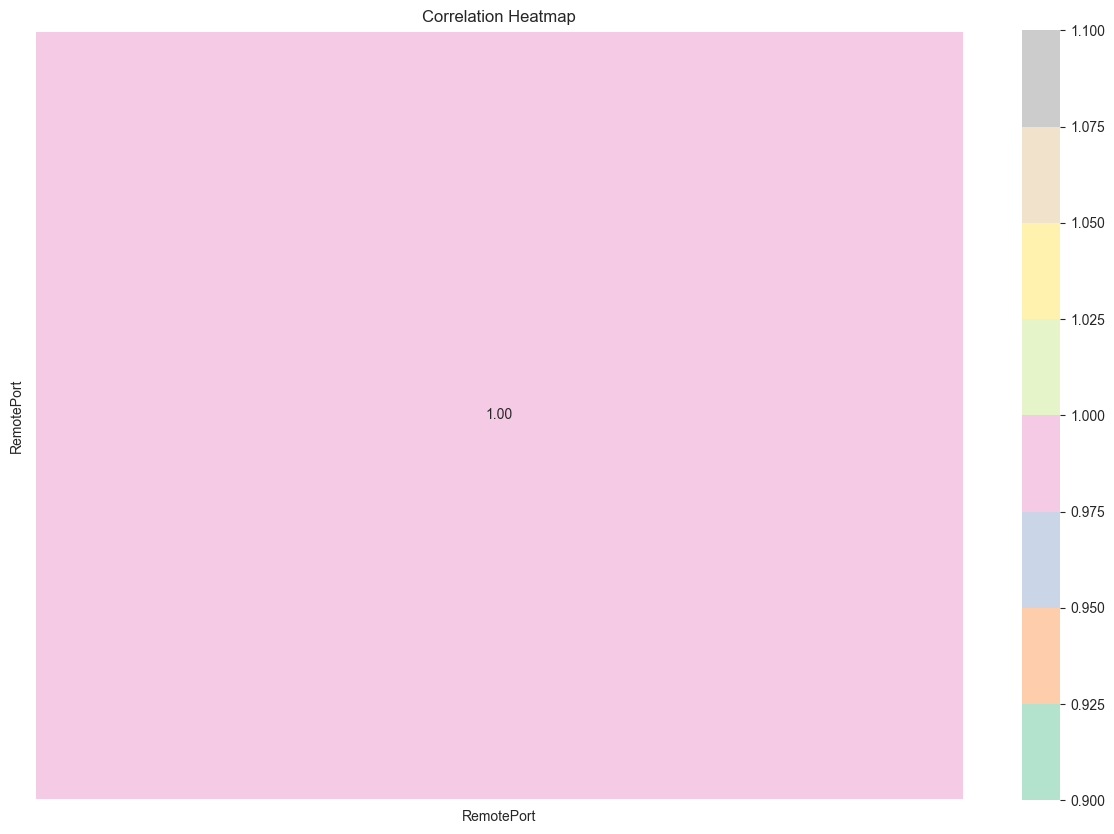

In [11]:
plt.figure(figsize=(15, 10))

# Filtra solo columnas numéricas
numeric_df = df_ueba.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

Como me temía al ver la salida del comando *df_ueba.info()*, algunos ploteos no se ven tan interesantes debido a que sólo tenemos una variable de tipo numérica, las demás están codificadas como categorías/object. Al menos esto sirvió para poder retomar el código en actividades futuras.

**Continuando con el PDF...**

Ahora, necesitamos crear características. Aquí, utilizamos principalmente opciones de características numéricas (números enteros) y características categóricas, de un número discreto de categorías.

Las siguientes columnas quedan como características potenciales: 
    
    • HostIP: Característica numérica.
    • RemoteIP: Característica numérica.
    • RemotePort: Característica categórica.
    • HostLocation: Característica categórica.
    • RemoteIPLocation: Característica categórica.
    • ProcessImage: Característica categórica.

Crearemos características numéricas a partir de direcciones IP debido a la sencillez de convertir IP's a #'s enteros.

In [12]:
import ipaddress 

def iptointeger(ip): 
    return int(ipaddress.ip_address(ip)) 

In [13]:
ueba_features = pd.DataFrame() 
ueba_features['HostIP'] = df_ueba['HostIP'].apply(iptointeger) 
ueba_features['RemoteIP'] = df_ueba['RemoteIP'].apply(iptointeger) 
df_ueba["RemotePort"].value_counts().sort_index() 

RemotePort
22       7
80      40
389      1
443      7
464      4
465      2
636      2
3389     5
5938     2
8080    11
Name: count, dtype: int64

In [14]:
ueba_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   HostIP    81 non-null     int64
 1   RemoteIP  81 non-null     int64
dtypes: int64(2)
memory usage: 1.4 KB


Para las vars. categóricas usaremos One-Hot encodeing.

In [15]:
from sklearn.preprocessing import OneHotEncoder 

encoder = OneHotEncoder( 
    sparse_output=False).set_output(transform="pandas") 
categorical_encoded = encoder.fit_transform( 
    df_ueba[['RemotePort', 'HostLocation', 'RemoteIPLocation', 'ProcessImage']])

#Asignamos las características categóricas de nuevo al DataFrame de características
ueba_features[categorical_encoded.columns] = categorical_encoded

Para igualar la influencia de las características, las escalamos a valores entre 0 y 1 (escalado Min-Max).

In [16]:
min_max_scaler = MinMaxScaler() 
ueba_features_scaled = min_max_scaler.fit_transform(ueba_features)

**Detección de anomalías**

Dado que no disponemos de etiquetas para nuestros datos, elegimos un método del subconjunto de detección de anomalías no supervisada.

La función de decisión nos proporciona una forma de puntuación de anomalía. Cuanto menor sea la puntuación, más anómalo será el punto de datos.

In [17]:
from sklearn.ensemble import IsolationForest 

isolationforest = IsolationForest(n_estimators=100, contamination=0.05)  
anomaly_labels = isolationforest.fit_predict(ueba_features_scaled) 

In [18]:
anomaly_scores = isolationforest.decision_function( 
    ueba_features_scaled) 
ueba_features['anomaly_labels'] = anomaly_labels 
ueba_features['anomaly_scores'] = anomaly_scores 

<Axes: >

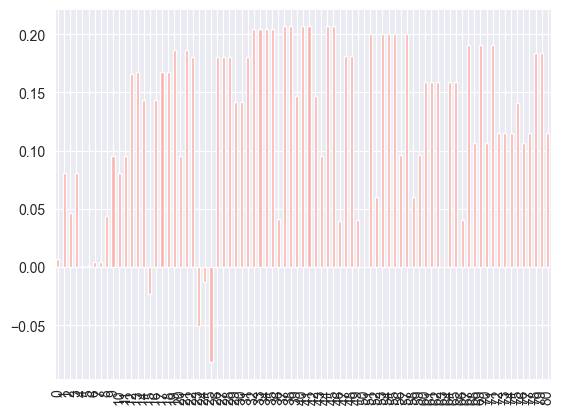

In [19]:
ueba_features['anomaly_scores'].plot(kind='bar') 

El gráfico muestra dos valores atípicos muy significativos con funciones de decisión negativas. Esto demuestra la alta confianza del detector de anomalías en que estos dos puntos de datos son anómalos.

In [20]:
display(ueba_features)

,HostIP,RemoteIP,RemotePort_22,RemotePort_80,RemotePort_389,RemotePort_443,RemotePort_464,RemotePort_465,RemotePort_636,RemotePort_3389,...,RemoteIPLocation_USA,ProcessImage_HTTP_Client.exe,ProcessImage_LDAP_Client.exe,ProcessImage_Mail_Client.exe,ProcessImage_RDP_Client.exe,ProcessImage_SSH_Client.exe,ProcessImage_custom_script.py,ProcessImage_fast_script.py,anomaly_labels,anomaly_scores
0,3232235778,167772420,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.006960
1,3232235778,167772420,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.080447
2,3232235778,167772420,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.046550
3,3232235778,167772420,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.080447
4,3232235778,167772421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.001080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,3232235779,167772164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.106463
77,3232235779,2310042796,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.114802
78,3232235779,2310042796,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.184250
79,3232235779,2310042796,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.184250


In [22]:
# Filtrar las filas donde los valores de 'anomaly_labels' son negativos
filas_negativas = ueba_features[ueba_features['anomaly_labels'] < 0]

import pandas as pd
#Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)
display(filas_negativas)

,HostIP,RemoteIP,RemotePort_22,RemotePort_80,RemotePort_389,RemotePort_443,RemotePort_464,RemotePort_465,RemotePort_636,RemotePort_3389,RemotePort_5938,RemotePort_8080,HostLocation_USA,RemoteIPLocation_China,RemoteIPLocation_France,RemoteIPLocation_Portugal,RemoteIPLocation_UK,RemoteIPLocation_USA,ProcessImage_HTTP_Client.exe,ProcessImage_LDAP_Client.exe,ProcessImage_Mail_Client.exe,ProcessImage_RDP_Client.exe,ProcessImage_SSH_Client.exe,ProcessImage_custom_script.py,ProcessImage_fast_script.py,anomaly_labels,anomaly_scores
15,3232235778,3897504376,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-0.022765
23,3232235778,201357573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1,-0.050242
24,3232235778,167772164,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1,-0.012916
25,3232235778,3861584680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1,-0.081549


In [23]:
#RESTAURAR EL COMPORTAMIENTO DE PANDAS PARA QUE SÓLO MUESTRE ALGUNAS COLUMNAS
pd.reset_option('display.max_columns')

Podemos observar que las ubicaciones de estos puntos también son diferentes. Por ejemplo, aquí podemos ver China y Portugal como ubicaciones de la IP de destino, lo cual difiere de ubicaciones más comunes en este conjunto de datos, como el Reino Unido o EE. UU.

Además de los verdaderos positivos, también podemos ver otros dos puntos que parecen valores atípicos. Estos son falsos positivos y apenas superan el límite de cero en términos de puntuaciones de anomalía. Sin embargo, se caracterizan por ser valores atípicos, en parte debido al hiperparámetro de contaminación que determina el porcentaje de valores atípicos esperados en el conjunto de datos.

Uno de los problemas generales con la detección de anomalías no supervisada es la presencia de falsos positivos. La razón es que, en cualquier método de detección de valores atípicos, el límite de decisión depende de hiperparámetros, y es difícil conocer sus valores con antelación.

**Forma original de ver las anomalías (parte final del PDF):**

In [25]:
display(ueba_features[ueba_features['anomaly_labels']==-1]) 

,HostIP,RemoteIP,RemotePort_22,RemotePort_80,RemotePort_389,RemotePort_443,RemotePort_464,RemotePort_465,RemotePort_636,RemotePort_3389,...,RemoteIPLocation_USA,ProcessImage_HTTP_Client.exe,ProcessImage_LDAP_Client.exe,ProcessImage_Mail_Client.exe,ProcessImage_RDP_Client.exe,ProcessImage_SSH_Client.exe,ProcessImage_custom_script.py,ProcessImage_fast_script.py,anomaly_labels,anomaly_scores
15,3232235778,3897504376,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-0.022765
23,3232235778,201357573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1,-0.050242
24,3232235778,167772164,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1,-0.012916
25,3232235778,3861584680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1,-0.081549


In [27]:
ueba_features[ueba_features['anomaly_labels']==-1][['HostLocation_USA', 'RemoteIPLocation_China', 
                                                    'RemoteIPLocation_France', 
                                                    'RemoteIPLocation_Portugal', 'RemoteIPLocation_UK', 
                                                    'RemoteIPLocation_USA', 'anomaly_labels', 'anomaly_scores']] 

,HostLocation_USA,RemoteIPLocation_China,RemoteIPLocation_France,RemoteIPLocation_Portugal,RemoteIPLocation_UK,RemoteIPLocation_USA,anomaly_labels,anomaly_scores
15,1.0,0.0,1.0,0.0,0.0,0.0,-1,-0.022765
23,1.0,1.0,0.0,0.0,0.0,0.0,-1,-0.050242
24,1.0,0.0,0.0,0.0,1.0,0.0,-1,-0.012916
25,1.0,0.0,0.0,1.0,0.0,0.0,-1,-0.081549


<Axes: >

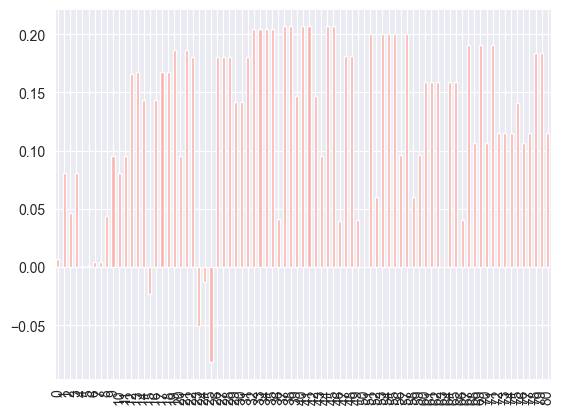

In [28]:
ueba_features['anomaly_scores'].plot(kind='bar')

In [30]:
display(ueba_features[ueba_features['anomaly_labels']==-1]) 

,HostIP,RemoteIP,RemotePort_22,RemotePort_80,RemotePort_389,RemotePort_443,RemotePort_464,RemotePort_465,RemotePort_636,RemotePort_3389,...,RemoteIPLocation_USA,ProcessImage_HTTP_Client.exe,ProcessImage_LDAP_Client.exe,ProcessImage_Mail_Client.exe,ProcessImage_RDP_Client.exe,ProcessImage_SSH_Client.exe,ProcessImage_custom_script.py,ProcessImage_fast_script.py,anomaly_labels,anomaly_scores
15,3232235778,3897504376,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-0.022765
23,3232235778,201357573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1,-0.050242
24,3232235778,167772164,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1,-0.012916
25,3232235778,3861584680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1,-0.081549


**Probar de nuevo la matriz de correlación y el gráfico de densidad**

In [31]:
ueba_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   HostIP                         81 non-null     int64  
 1   RemoteIP                       81 non-null     int64  
 2   RemotePort_22                  81 non-null     float64
 3   RemotePort_80                  81 non-null     float64
 4   RemotePort_389                 81 non-null     float64
 5   RemotePort_443                 81 non-null     float64
 6   RemotePort_464                 81 non-null     float64
 7   RemotePort_465                 81 non-null     float64
 8   RemotePort_636                 81 non-null     float64
 9   RemotePort_3389                81 non-null     float64
 10  RemotePort_5938                81 non-null     float64
 11  RemotePort_8080                81 non-null     float64
 12  HostLocation_USA               81 non-null     float

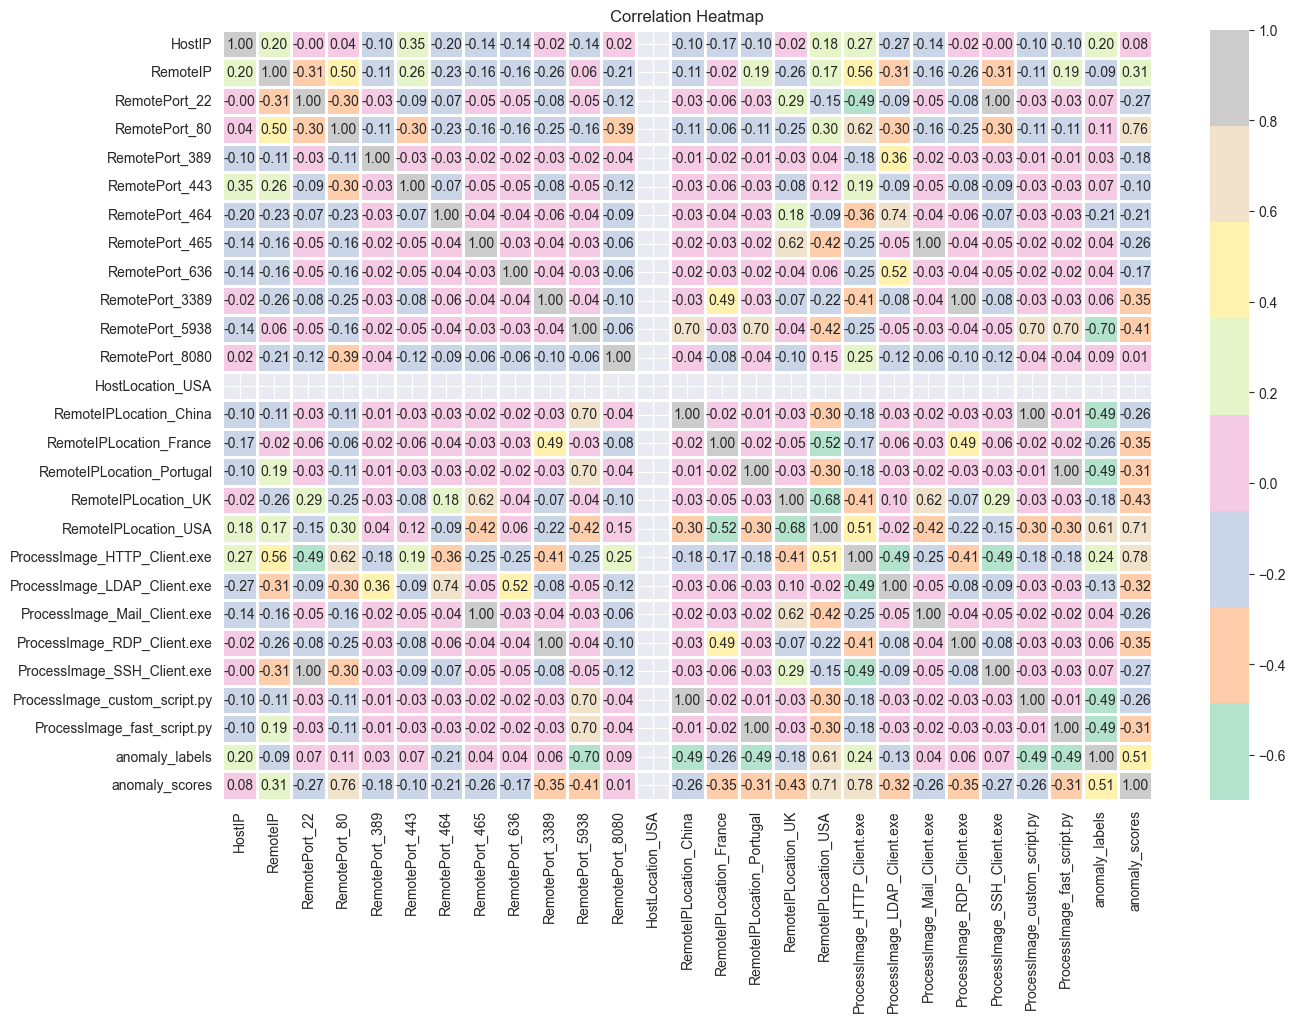

In [33]:
plt.figure(figsize=(15, 10))

# Filtra solo columnas numéricas
numeric_df = ueba_features.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

In [37]:
#MOSTRAR LAS CORRELACIONES MÁS ALTAS
import pandas as pd
import numpy as np

numeric_df = ueba_features.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr().abs()  #usar valor absoluto

#Eliminar la diagonal
np.fill_diagonal(corr_matrix.values, np.nan)

corr_pairs = (
    corr_matrix.stack()
    .reset_index()
    .rename(columns={'level_0': 'Variable 1', 'level_1': 'Variable 2', 0: 'Correlación'})
)

#Elimina duplicados (A-B y B-A)
corr_pairs['Pareja Ordenada'] = corr_pairs.apply(
    lambda row: tuple(sorted([row['Variable 1'], row['Variable 2']])), axis=1
)
corr_pairs = corr_pairs.drop_duplicates(subset='Pareja Ordenada').drop(columns='Pareja Ordenada')

#Ordena por correlación descendente
corr_pairs = corr_pairs.sort_values(by='Correlación', ascending=False)
display(corr_pairs.head(20))


,Variable 1,Variable 2,Correlación
193,RemotePort_465,ProcessImage_Mail_Client.exe,1.000000
244,RemotePort_3389,ProcessImage_RDP_Client.exe,1.000000
70,RemotePort_22,ProcessImage_SSH_Client.exe,1.000000
321,RemoteIPLocation_China,ProcessImage_custom_script.py,1.000000
372,RemoteIPLocation_Portugal,ProcessImage_fast_script.py,1.000000
449,ProcessImage_HTTP_Client.exe,anomaly_scores,0.780591
99,RemotePort_80,anomaly_scores,0.757981
167,RemotePort_464,ProcessImage_LDAP_Client.exe,0.741057
424,RemoteIPLocation_USA,anomaly_scores,0.711019
261,RemotePort_5938,RemoteIPLocation_China,0.702673


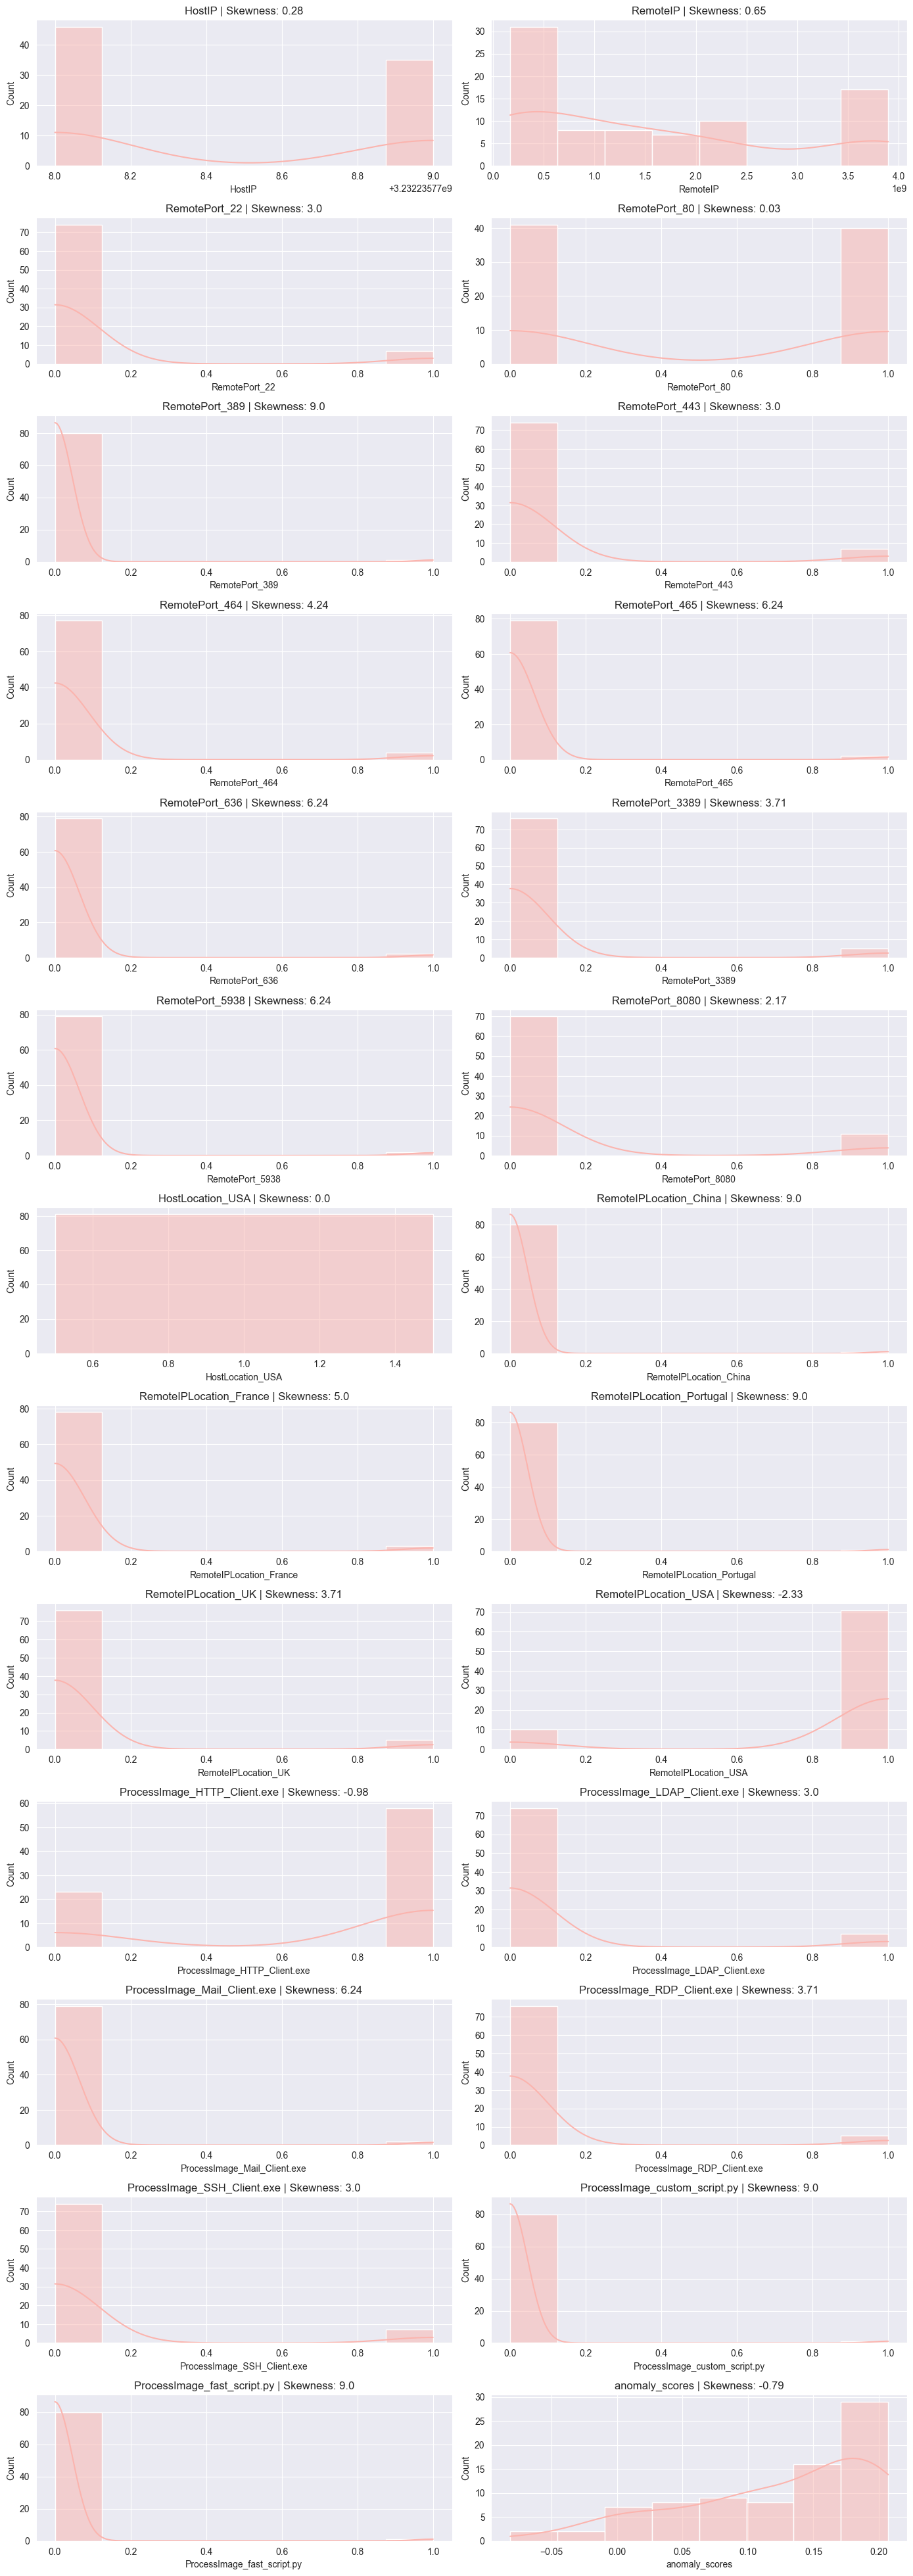

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

numerical_columns = ueba_features.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(ueba_features[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(ueba_features[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

Como vemos, la codificación One-hot fue fundamental para poder plotear el gráfico de densidad y la matriz de correlación.

Podemos notar un efecto curioso en la matriz de correlación, y es que se hizo una especie de cruz al medio que separa en cuatro cuadrantes la matriz. Independientemente de eso, podemos observar correlaciones muy fuertes, por ejemplo, *ProcessImage_custom_script.py* y *RemoteIPLocation_China* tienen una correlación de 1.0, lo que significa que tienen una relación lineal perfecta positiva. En términos matemáticos, esto significa que no hay variación o desviación significativa en la relación entre ellas, por lo que cada vez que *RemoteIPLocation_China* es 1, también lo es *ProcessImage_custom_script.py*, y viceversa. Lo mismo sucede con otras variables:

    - ProcessImage_Mail_Client.exe y RemotePort_465
    - ProcessImage_RDP_Client.exe y RemotePort_3389
    - ProcessImage_SSH_Client.exe y RemotePort_22
    - RemoteIPLocation_Portugal y ProcessImage_fast_script.py

Esto es interesante porque entonces una variable predice completamente la otra. Quizás a primera vista esto parezca ilusionante, pero antes debemos analizarlas con detenimiento ya que alguna podría simplemente representar el comportamiento típico del tráfico de red. Por ejemplo, la correlación de *RemotePort_465* y *ProcessImage_Mail_Client.exe* perfectamente puede significar que cada vez que se abre el puerto 465 (usado para SMTP seguro), se lanza el cliente de correo (comportamiento típico de aplicaciones de envío de correos). Algo similar ocurre con las otras variables de puertos. El uso de RDP (escritorio remoto) siempre está vinculado a la ejecución del cliente RDP. Y la conexión por SSH siempre implica ejecución del cliente SSH. El protocolo RDP puede ser interesante de cara a detectar sesiones remotas, sin embargo, **hablemos de las correlaciones perfectas más interesantes**. La correlación entre *RemoteIPLocation_China* y *ProcessImage_custom_script.py* **puede implicar una ejecución automática de un script** cuando la IP remota es de China, lo que puede ser señal de malware o comportamiento malicioso. Y lo mismo aplica para el caso de *RemoteIPLocation_Portugal* y *ProcessImage_fast_script.py*

Seguí con mi análisis de correlación entre variables en busca de posible uso de proxies o VPN (cosa que seguramente usaría un atacante), sin embargo, no supe encontrar algo que indicara el uso de estas herramientas. Aunque si noté que **las variables relacionadas a HTTP (como la del puerto 80 y *ProcessImage_HTTP_Client.exe*) tienen una alta correlación con *anomaly_scores***, lo que sugiere que esta conexión tan fuerte con las anomalías y HTTP se deba a que exista tráfico web sospechoso.

Sobre el gráfico de densidad no hay mucho que decir, siento que como las variables categóricas se volvieron binarias (por el one-hot encoding) vemos distribuciones similares para casi todas las variables de su tipo. Tal vez podríamos mencionar que el gráfico de *anomaly_score* tiene una tendencia lineal ascendente, pero esto es normal porque según aumenta el conteo de observaciones naturalmente se irá acumulando la puntuación de anomalías.